[Modelo axonal reducido] Velocidad — mielinizado: 0.09 m/s
[Modelo axonal reducido] Velocidad — desmielinizado: nan m/s


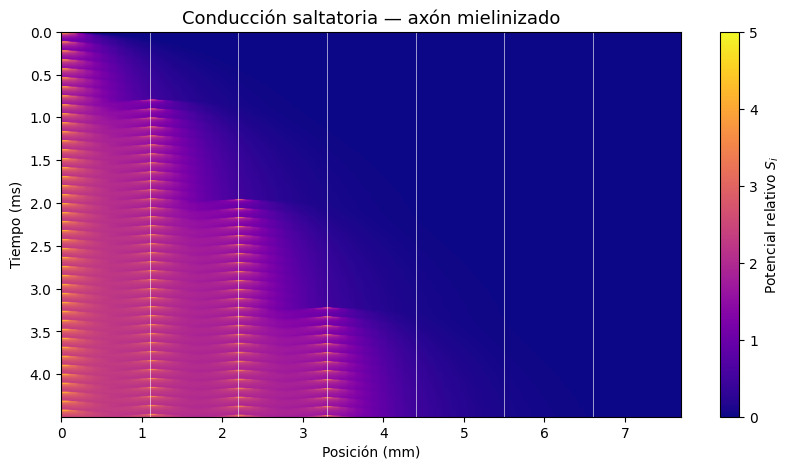

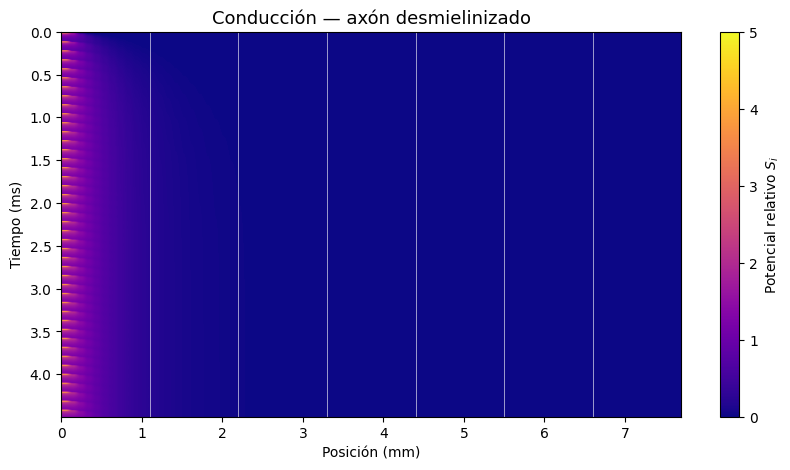

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

plt.rcParams['animation.html'] = 'jshtml'

# ==========================================================
# GEOMETRÍA DEL AXÓN — MODELO REDUCIDO
# ==========================================================
dx_mm = 0.1              # resolución espacial: 0.1 mm por compartimento
dx_m  = dx_mm * 1e-3
dt_ms = 0.005            # paso de tiempo global: 0.005 ms
dt_s  = dt_ms * 1e-3

N_nodes        = 8       # número de nodos de Ranvier
seg_internodo  = 10      # segmentos pasivos por internodo

comp_types = []
for k in range(N_nodes):
    comp_types.append("node")
    if k < N_nodes - 1:
        for _ in range(seg_internodo):
            comp_types.append("internode")

N = len(comp_types)
x_mm = np.arange(N) * dx_mm

is_node = np.array([t == "node" for t in comp_types])
is_internode = ~is_node

# ==========================================================
# PARÁMETROS DE REFERENCIA (consistentes con el TEXTO)
# ==========================================================

Ra_ref       = 70.0          # Ω·cm
Rm_ref_node  = 70.0          # Ω·cm²
Rm_ref_int   = 20000.0       # Ω·cm²
Cm_ref_node  = 2.0e-6        # F/cm²
Cm_ref_int   = 0.04e-6       # F/cm²

# Constantes de escala
D0_node  = 0.40
D0_int   = 0.50
L0_node  = 0.02
L0_int   = 0.005


def compute_D_dimless(Ra, Cm, is_node_flag):
    Ra_t = Ra / Ra_ref
    Cm_ref = Cm_ref_node if is_node_flag else Cm_ref_int
    Cm_t = Cm / Cm_ref
    D0 = D0_node if is_node_flag else D0_int
    return D0 / (Ra_t * Cm_t)

def compute_leak_dimless(Rm, Cm, is_node_flag):
    Rm_ref = Rm_ref_node if is_node_flag else Rm_ref_int
    Cm_ref = Cm_ref_node if is_node_flag else Cm_ref_int
    Rm_t = Rm / Rm_ref
    Cm_t = Cm / Cm_ref
    L0 = L0_node if is_node_flag else L0_int
    return L0 / (Rm_t * Cm_t)

# ==========================================================
# SIMULACIÓN — MODELO AXONAL REDUCIDO
# ==========================================================
Smax  = 5.0
Srest = 0.0

def simulate_axon(Ra_node, Ra_int,
                  Rm_node, Rm_int,
                  Cm_node, Cm_int,
                  reinicio=0.10, refrac_steps=15,
                  T_steps=900):

    D = np.zeros(N)
    leak = np.zeros(N)

    for i in range(N):
        if is_node[i]:
            D[i]    = compute_D_dimless(Ra_node, Cm_node, True)
            leak[i] = compute_leak_dimless(Rm_node, Cm_node, True)
        else:
            D[i]    = compute_D_dimless(Ra_int, Cm_int, False)
            leak[i] = compute_leak_dimless(Rm_int, Cm_int, False)

    D = np.clip(D, 0.0, 0.45)

    S = np.zeros(N)
    hist = np.zeros((T_steps, N))

    first_node = np.where(is_node)[0][0]
    S[first_node] = Smax

    refrac = np.zeros(N, dtype=int)
    thr = reinicio * Smax

    for t in range(T_steps):
        hist[t] = S

        left  = np.r_[S[0], S[:-1]]
        right = np.r_[S[1:], S[-1]]

        diff = D * (left + right - 2.0 * S)
        S_new = S + diff - leak * (S - Srest)

        for i in np.where(is_node)[0]:
            if refrac[i] > 0:
                refrac[i] -= 1
            else:
                if S_new[i] > thr:
                    S_new[i] = Smax
                    refrac[i] = refrac_steps

        S = np.clip(S_new, 0.0, Smax)

    return hist

# ==========================================================
# CASOS: MIELINIZADO vs DESMIELINIZADO
# ==========================================================

hist_myelin = simulate_axon(
    Ra_node = 70.0,
    Ra_int  = 70.0,
    Rm_node = 70.0,
    Rm_int  = 20000.0,
    Cm_node = 2.0e-6,
    Cm_int  = 0.04e-6,
    reinicio=0.10,
    refrac_steps=20,
    T_steps=900
)

hist_demyel = simulate_axon(
    Ra_node = 70.0,
    Ra_int  = 70.0,
    Rm_node = 70.0,
    Rm_int  = 5000.0,
    Cm_node = 2.0e-6,
    Cm_int  = 0.10e-6,
    reinicio=0.10,
    refrac_steps=20,
    T_steps=900
)

# ==========================================================
# DETECCIÓN DE VELOCIDAD
# ==========================================================
def detect_velocity(hist):
    T_steps, _ = hist.shape
    node_idx = np.where(is_node)[0]
    activation_times = []

    for i in node_idx:
        trace = hist[:, i]
        above = trace >= 0.6 * Smax
        if not np.any(above):
            activation_times.append(np.nan)
        else:
            activation_times.append(np.argmax(above))

    activation_times = np.array(activation_times, float)
    valid = ~np.isnan(activation_times)

    if np.sum(valid) < 2:
        return np.nan, activation_times

    idx_valid = np.where(valid)[0]
    x_real = idx_valid * dx_m
    t_real = activation_times[idx_valid] * dt_s

    try:
        v = np.polyfit(t_real, x_real, 1)[0]
    except:
        v = np.nan

    return v, activation_times

v_m, act_m = detect_velocity(hist_myelin)
v_d, act_d = detect_velocity(hist_demyel)

print(f"[Modelo axonal reducido] Velocidad — mielinizado: {v_m:.2f} m/s")
print(f"[Modelo axonal reducido] Velocidad — desmielinizado: {v_d:.2f} m/s")

# ==========================================================
# HEATMAP ESPACIO–TIEMPO
# ==========================================================
def plot_spacetime_heatmap(hist, title="Mapa espacio–tiempo", cmap='plasma'):
    T_steps, _ = hist.shape
    t = np.arange(T_steps) * dt_ms

    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(
        hist,
        extent=[x_mm[0], x_mm[-1], t[-1], t[0]],
        aspect='auto',
        cmap=cmap
    )

    for i in np.where(is_node)[0]:
        ax.axvline(x_mm[i], color='white', alpha=0.6, lw=0.7)

    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Posición (mm)")
    ax.set_ylabel("Tiempo (ms)")
    plt.colorbar(im, ax=ax, label="Potencial relativo $S_i$")
    plt.show()

plot_spacetime_heatmap(
    hist_myelin,
    title="Conducción saltatoria — axón mielinizado"
)

plot_spacetime_heatmap(
    hist_demyel,
    title="Conducción — axón desmielinizado"
)

# ==========================================================
# ANIMACIÓN 1D
# ==========================================================
fig, ax = plt.subplots(figsize=(9, 3))
line1, = ax.plot([], [], 'dodgerblue', lw=2, label='Mielinizado')
line2, = ax.plot([], [], 'orange', lw=2, label='Desmielinizado')

ax.set_ylim(-0.5, Smax + 0.5)
ax.set_xlim(0, x_mm[-1])
ax.set_title("Propagación del potencial — modelo axonal reducido")
ax.set_xlabel("Posición (mm)")
ax.set_ylabel("Potencial relativo $S_i$")
ax.legend(loc='upper right')

for i in np.where(is_node)[0]:
    ax.axvspan(x_mm[i]-0.5*dx_mm, x_mm[i]+0.5*dx_mm, color='tomato', alpha=0.2)

time_text = ax.text(0.70, 0.9, "", transform=ax.transAxes, fontsize=10)

def init_anim():
    line1.set_data([], [])
    line2.set_data([], [])
    time_text.set_text("")
    return line1, line2, time_text

def update_anim(f):
    line1.set_data(x_mm, hist_myelin[f])
    line2.set_data(x_mm, hist_demyel[f])
    time_text.set_text(f"t = {f*dt_ms:.2f} ms")
    return line1, line2, time_text

plt.close(fig)


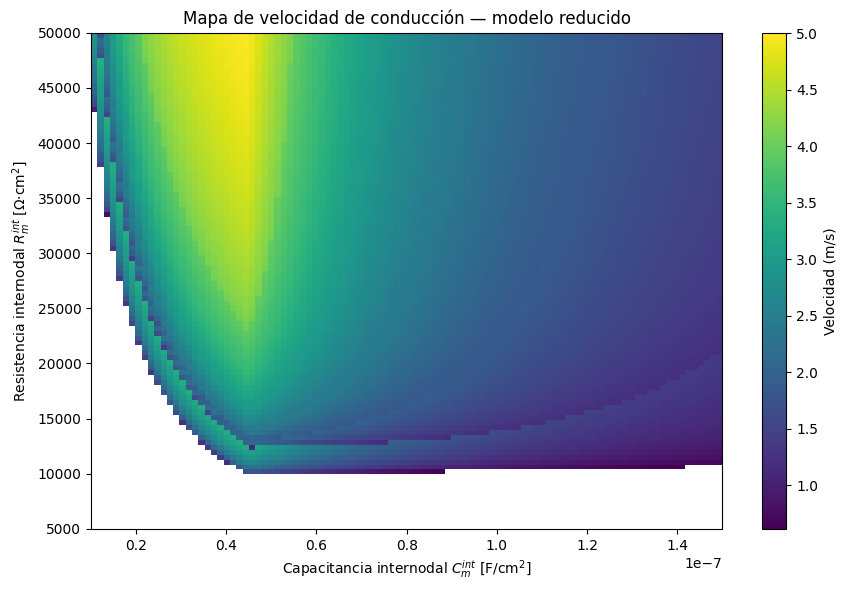

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# GEOMETRÍA CRRSS REDUCIDO
# ==========================================================
dx_mm = 0.1
dx_m  = dx_mm * 1e-3

N_nodes = 8
seg_internode = 10

comp_types = []
for k in range(N_nodes):
    comp_types.append("node")
    if k < N_nodes - 1:
        comp_types.extend(["internode"] * seg_internode)

N = len(comp_types)
is_node = np.array([c == "node" for c in comp_types])

# ==========================================================
# PARÁMETROS BIOFÍSICOS DE REFERENCIA (CORREGIDOS)
# ==========================================================
Ra_ref = 70.0           # Ω·cm (texto)
Rm_ref_node = 70.0      # Ω·cm² (texto)
Rm_ref_int  = 20000.0   # Ω·cm² (efectivo-mielina)
Cm_ref_node = 2e-6      # F/cm² (texto)
Cm_ref_int  = 0.04e-6   # F/cm² (tomado de literatura)

# Constantes del modelo (se mantienen)
D0_node = 0.40
D0_int  = 0.50
L0_node = 0.02
L0_int  = 0.005

def compute_D(Ra, Cm, isnode):
    Ra_t  = Ra / Ra_ref
    Cm_ref = Cm_ref_node if isnode else Cm_ref_int
    Cm_t = Cm / Cm_ref
    return (D0_node if isnode else D0_int) / (Ra_t * Cm_t)

def compute_leak(Rm, Cm, isnode):
    Rm_ref = Rm_ref_node if isnode else Rm_ref_int
    Cm_ref = Cm_ref_node if isnode else Cm_ref_int
    Rm_t = Rm / Rm_ref
    Cm_t = Cm / Cm_ref
    return (L0_node if isnode else L0_int) / (Rm_t * Cm_t)

# ==========================================================
# DINÁMICA
# ==========================================================
Smax = 5.0
Srest = 0.0

def simulate(Ra_node, Ra_int, Rm_node, Rm_int, Cm_node, Cm_int,
             reinicio=0.10, refrac_steps=15, T_steps=900):

    D    = np.zeros(N)
    leak = np.zeros(N)

    for i in range(N):
        if is_node[i]:
            D[i]    = compute_D(Ra_node, Cm_node, True)
            leak[i] = compute_leak(Rm_node, Cm_node, True)
        else:
            D[i]    = compute_D(Ra_int, Cm_int, False)
            leak[i] = compute_leak(Rm_int, Cm_int, False)

    D = np.clip(D, 0, 0.45)

    S = np.zeros(N)
    hist = np.zeros((T_steps, N))

    first_node = np.where(is_node)[0][0]
    S[first_node] = Smax

    refrac = np.zeros(N, int)
    thr = reinicio * Smax

    for t in range(T_steps):
        hist[t] = S

        left  = np.r_[S[0], S[:-1]]
        right = np.r_[S[1:], S[-1]]

        diff = D * (left + right - 2*S)
        S_new = S + diff - leak * (S - Srest)

        for i in np.where(is_node)[0]:
            if refrac[i] > 0:
                refrac[i] -= 1
            elif S_new[i] > thr:
                S_new[i] = Smax
                refrac[i] = refrac_steps

        S = np.clip(S_new, 0, Smax)

    return hist

# ==========================================================
# BARRIDO PARAMÉTRICO (200×200)
# ==========================================================
Rm_vals = np.linspace(5000, 50000, 100)      # 5–50 kΩ·cm² según texto
Cm_vals = np.linspace(0.01e-6, 0.15e-6, 100) # 0.02–0.10 μF/cm²

vel_map = np.zeros((len(Rm_vals), len(Cm_vals)))

# PARÁMETROS NODALES CORRECTOS DEL TEXTO
Ra_node = 70.0
Ra_int  = 70.0
Rm_node = 70.0
Cm_node = 2.0e-6

dt_s = 2e-6   # 2 microsegundos

def slope_idx(hist):
    node_idx = np.where(is_node)[0]
    activation = []

    for i in node_idx:
        trace = hist[:, i]
        above = trace > 0.6 * Smax
        if not np.any(above):
            activation.append(np.nan)
        else:
            activation.append(np.argmax(above))

    activation = np.array(activation, float)
    valid = ~np.isnan(activation)

    if np.sum(valid) < 2:
        return np.nan

    t = activation[valid]
    x = node_idx[valid]
    coef = np.polyfit(t, x, 1)
    return coef[0]

# BARRIDO
for i, Rm_int in enumerate(Rm_vals):
    for j, Cm_int in enumerate(Cm_vals):
        hist = simulate(Ra_node, Ra_int, Rm_node, Rm_int, Cm_node, Cm_int)
        s = slope_idx(hist)
        vel_map[i, j] = np.nan if np.isnan(s) else s * dx_m / dt_s

# ==========================================================
# HEATMAP FINAL
# ==========================================================
plt.figure(figsize=(9, 6))

plt.imshow(
    vel_map,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    extent=[Cm_vals[0], Cm_vals[-1], Rm_vals[0], Rm_vals[-1]]
)

plt.colorbar(label="Velocidad (m/s)")
plt.xlabel(r"Capacitancia internodal $C_m^{int}$ [F/cm$^2$]")
plt.ylabel(r"Resistencia internodal $R_m^{int}$ [Ω·cm$^2$]")
plt.title("Mapa de velocidad de conducción — modelo reducido")

plt.tight_layout()
plt.show()
